# Heterogeneous Graph Neural Network (beta)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

## Dataload

In [113]:
import pandas as pd

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

playerFrames = pd.read_csv('../scrape-parse/demo/parse/2023/playerFrames/blast-premier-fall-groups-2023-natus-vincere-vs-g2-bo3-qpKifIreD-H1wjvSAUFqcRnatus-vincere-vs-g2-m1-inferno.dem.csv')

pf = playerFrames[['tick', 'roundNum', 'seconds', 'side', 'name', 'x', 'y', 'z',
    'eyeX', 'eyeY', 'eyeZ', 'velocityX', 'velocityY', 'velocityZ',
    'hp', 'armor', 'activeWeapon',
    'flashGrenades', 'smokeGrenades', 'heGrenades', 'totalUtility',
    'isAlive', 'isReloading', 'isDefusing', 'isPlanting', 'isUnknown',
    'equipmentValue', 'equipmentValueRoundStart', 'hasHelmet',
    'hasDefuse', 'hasBomb'
    ]]

rounds = pd.read_csv('../scrape-parse/demo/parse/2023/rounds/blast-premier-fall-groups-2023-natus-vincere-vs-g2-bo3-qpKifIreD-H1wjvSAUFqcRnatus-vincere-vs-g2-m1-inferno.dem.csv')
rounds = rounds[['roundNum', 'tScore', "ctScore" ,'endTScore', 'endCTScore']]

kills = pd.read_csv("../scrape-parse/demo/parse/2023/kills/blast-premier-fall-groups-2023-natus-vincere-vs-g2-bo3-qpKifIreD-H1wjvSAUFqcRnatus-vincere-vs-g2-m1-inferno.dem.csv")

pf = pf.merge(rounds, on='roundNum')
pf["winsRounds"] = pf.apply(lambda x: 
    1 if ( (x['side'] == 'T') and (x['endTScore'] > x['tScore']) ) or ( (x['side'] == 'CT') and (x['endCTScore'] > x['ctScore']) )
    else 0, axis=1)

pf['kills'] = 0
pf['deaths'] = 0

for index, row in kills.iterrows():
    pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'kills'] += 1
    pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'deaths'] += 1

In [114]:
from math import floor

# Create dummie cols
dummies = pd.get_dummies(pf['activeWeapon'], prefix="activeWeapon",drop_first=False)[['activeWeapon_AK-47','activeWeapon_Knife','activeWeapon_AWP','activeWeapon_M4A1','activeWeapon_Smoke Grenade','activeWeapon_M4A4','activeWeapon_Galil AR','activeWeapon_Desert Eagle','activeWeapon_Flashbang','activeWeapon_Glock-18','activeWeapon_USP-S']]
dummies = dummies*1
pf = pf.merge(dummies, left_index = True, right_index = True, how = 'left')

# Rounded-down seconds
pf['floorSec'] = pf['seconds'].apply(lambda x: floor(x))
pf[['roundNum', 'floorSec', 'seconds']].iloc[30000:30500]

,roundNum,floorSec,seconds
30000,4,86,86.90625
30001,4,86,86.90625
30002,4,86,86.90625
30003,4,86,86.90625
30004,4,86,86.90625
...,...,...,...
30495,4,93,93.03125
30496,4,93,93.03125
30497,4,93,93.03125
30498,4,93,93.03125


C:\Users\szmid\AppData\Local\Temp\ipykernel_8620\37965649.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(plotData['x'].head(10), plotData['y'].head(10), c='purple', cmap='viridis',s=2)
C:\Users\szmid\AppData\Local\Temp\ipykernel_8620\37965649.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(plotData['x'].iloc[10:20], plotData['y'].iloc[10:20], c='yellow', cmap='viridis',s=2)


(-1000.0, 4000.0)

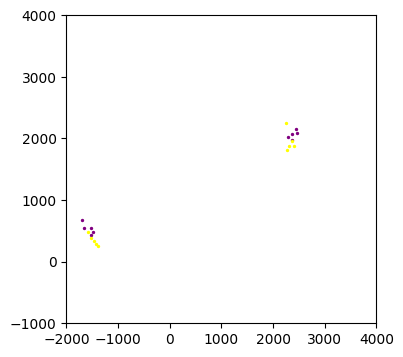

In [115]:
plotData = pf.drop_duplicates(subset=['floorSec', 'roundNum', 'name'])

plt.figure(figsize=(4,4))
plt.scatter(plotData['x'].head(10), plotData['y'].head(10), c='purple', cmap='viridis',s=2)
plt.scatter(plotData['x'].iloc[10:20], plotData['y'].iloc[10:20], c='yellow', cmap='viridis',s=2)
plt.xlim(-2000,4000)
plt.ylim(-1000,4000)

## Tasks

**A) Till this point**

The *secDf* dataframe contains the same information as *playerFrames*, but reduced to a second-by-second basis. 

**B) Next steps**

1. Separate the data to player-level and calculate player stats (kills, deaths in the match, etc.)
2. Check the nearest map-node for each player in each second
3. Copy / calculate graph-level features if nessesary (player alive on each side, remaining time, etc.), along with the target variable (win/loss)

### Player dataframes

In [129]:
# Calculate closest map-graph node
def find_closest(row):
    distances = np.sqrt((nodes['x'] - row['x'])**2 + (nodes['y'] - row['y'])**2)
    return nodes.loc[distances.idxmin(), 'nodeId']

# Separate team players, create empty object, read graph nodes
nodes = pd.read_csv('../graph/graph_models/manual/nodes_v1_4.csv')
startAsCTPlayerNames = pf[(pf['side'] == 'CT') & (pf['roundNum'] == 1)]['name'].unique()
startAsTPlayerNames = pf[(pf['side'] == 'T') & (pf['roundNum'] == 1)]['name'].unique()
players = {}

# Team 1: start on CT side
players[0] = pf[pf['name'] == startAsCTPlayerNames[0]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[1] = pf[pf['name'] == startAsCTPlayerNames[1]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[2] = pf[pf['name'] == startAsCTPlayerNames[2]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[3] = pf[pf['name'] == startAsCTPlayerNames[3]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[4] = pf[pf['name'] == startAsCTPlayerNames[4]].drop_duplicates(subset=['floorSec','roundNum']).copy()

# Team 2: start on T side
players[5] = pf[pf['name'] == startAsTPlayerNames[0]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[6] = pf[pf['name'] == startAsTPlayerNames[1]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[7] = pf[pf['name'] == startAsTPlayerNames[2]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[8] = pf[pf['name'] == startAsTPlayerNames[3]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[9] = pf[pf['name'] == startAsTPlayerNames[4]].drop_duplicates(subset=['floorSec','roundNum']).copy()

for idx, player in enumerate(players):
    
    players[idx] = players[idx].replace(True, 1)
    players[idx] = players[idx].replace(False, 0)
    players[idx]['isCT'] = players[idx]['side'].apply(lambda x: 1 if x == 'CT' else 0)
    players[idx]['closestId'] = players[idx].apply(find_closest, axis=1)

    del players[idx]['side']
    del players[idx]['activeWeapon']
    del players[idx]['winsRounds']

In [117]:
players[0]

,tick,roundNum,seconds,name,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,kills,deaths,activeWeapon_AK-47,activeWeapon_Knife,activeWeapon_AWP,activeWeapon_M4A1,activeWeapon_Smoke Grenade,activeWeapon_M4A4,activeWeapon_Galil AR,activeWeapon_Desert Eagle,activeWeapon_Flashbang,activeWeapon_Glock-18,activeWeapon_USP-S,floorSec,isCT,closestId
0,9648,1,0.078125,Aleksib,2291.713867,2031.145874,128.031250,2291.713867,2031.145874,192.093811,-7.701770,77.791405,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,155
81,9776,1,1.078125,Aleksib,2257.619873,2250.425293,128.031250,2257.619873,2250.425293,192.093811,-119.223747,218.292725,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,150
160,9904,1,2.078125,Aleksib,2139.303467,2464.421875,128.031250,2139.303467,2464.421875,192.093811,-133.440170,209.520645,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,153
240,10032,1,3.078125,Aleksib,1984.614868,2656.071533,128.031250,1984.614868,2656.071533,192.093811,-201.938309,147.380188,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,1,154
323,10160,1,4.078125,Aleksib,1755.860107,2754.217285,127.873169,1755.860107,2754.217285,191.935730,-235.700089,48.875271,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,1,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260768,569555,30,98.023438,Aleksib,1808.623657,-73.985199,129.338638,2115.815674,-345.349792,131.076218,58.659725,-16.911407,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,98,0,173
260849,569683,30,99.023438,Aleksib,1808.623657,-73.985199,129.338638,1947.831177,701.907715,224.093811,-1.382732,-0.726303,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,99,0,173
260925,569811,30,100.023438,Aleksib,1808.623657,-73.985199,129.338638,1947.679077,701.828247,206.076218,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,100,0,173
261008,569939,30,101.023438,Aleksib,1808.623657,-73.985199,129.338638,1947.679077,701.828247,206.076218,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,101,0,173


### Player-edges dataframe

In [130]:
playerEdges = None

for idx in range(0,len(players)):
    temp = players[idx][['roundNum','floorSec','closestId']].copy()
    temp['playerId'] = idx
    if playerEdges is None:
        playerEdges = temp
    else:
        playerEdges = pd.concat([playerEdges, temp])

In [131]:
playerEdges

,roundNum,floorSec,closestId,playerId
0,1,0,155,0
81,1,1,150,0
160,1,2,153,0
240,1,3,154,0
323,1,4,138,0
...,...,...,...,...
260761,30,98,163,9
260844,30,99,164,9
260921,30,100,163,9
261000,30,101,162,9


### Graph-level dataframe

In [144]:
# Copy players object
graph_players = {}
for idx in range(0,len(players)):
    graph_players[idx] = players[idx].copy()

colsNotToRename = ['tick', 'roundNum', 'seconds', 'floorSec']

# Rename columns except for tick, roundNum, seconds, floorSec
for idx in range(0,len(graph_players)):
    
    for col in graph_players[idx].columns:
        if col not in colsNotToRename:
            graph_players[idx].rename(columns={col: "player" + str(idx) + "_" + col}, inplace=True)

# Create a graph dataframe to store all players in 1 row per second
graph_data = graph_players[0].copy()

# Merge dataframes
for i in range(1, len(graph_players)):
    graph_data = graph_data.merge(graph_players[i], on=colsNotToRename)
    
graph_data = graph_data.merge(rounds, on=['roundNum'])
graph_data['CTwinsRound'] = graph_data.apply(lambda x: 
    1 if 
    (x['endCTScore'] > x['ctScore'])
    else 0, axis=1)
graph_data['team1AliveNum'] = graph_data[['player0_isAlive','player1_isAlive','player2_isAlive','player3_isAlive','player4_isAlive']].sum(axis=1)
graph_data['team2AliveNum'] = graph_data[['player5_isAlive','player6_isAlive','player7_isAlive','player8_isAlive','player9_isAlive']].sum(axis=1)
graph_data = graph_data[['roundNum','seconds','floorSec','team1AliveNum','team2AliveNum','CTwinsRound']]
graph_data

,roundNum,seconds,floorSec,team1AliveNum,team2AliveNum,CTwinsRound
0,1,0.078125,0,5,5,0
1,1,1.078125,1,5,5,0
2,1,2.078125,2,5,5,0
3,1,3.078125,3,5,5,0
4,1,4.078125,4,5,5,0
...,...,...,...,...,...,...
2715,30,98.023438,98,3,3,0
2716,30,99.023438,99,3,3,0
2717,30,100.023438,100,3,3,0
2718,30,101.023438,101,3,3,0


In [135]:
[k for k in graph_data.columns if 'player1' in k]

['player1_name',
 'player1_x',
 'player1_y',
 'player1_z',
 'player1_eyeX',
 'player1_eyeY',
 'player1_eyeZ',
 'player1_velocityX',
 'player1_velocityY',
 'player1_velocityZ',
 'player1_hp',
 'player1_armor',
 'player1_flashGrenades',
 'player1_smokeGrenades',
 'player1_heGrenades',
 'player1_totalUtility',
 'player1_isAlive',
 'player1_isReloading',
 'player1_isDefusing',
 'player1_isPlanting',
 'player1_isUnknown',
 'player1_equipmentValue',
 'player1_equipmentValueRoundStart',
 'player1_hasHelmet',
 'player1_hasDefuse',
 'player1_hasBomb',
 'player1_tScore',
 'player1_ctScore',
 'player1_endTScore',
 'player1_endCTScore',
 'player1_kills',
 'player1_deaths',
 'player1_activeWeapon_AK-47',
 'player1_activeWeapon_Knife',
 'player1_activeWeapon_AWP',
 'player1_activeWeapon_M4A1',
 'player1_activeWeapon_Smoke Grenade',
 'player1_activeWeapon_M4A4',
 'player1_activeWeapon_Galil AR',
 'player1_activeWeapon_Desert Eagle',
 'player1_activeWeapon_Flashbang',
 'player1_activeWeapon_Glock-18',

## Heterogeneous Graph Neural Network model

In [272]:
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero


In [282]:
dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]
data.metadata()

(['paper', 'author', 'institution', 'field_of_study'],
 [('author', 'affiliated_with', 'institution'),
  ('author', 'writes', 'paper'),
  ('paper', 'cites', 'paper'),
  ('paper', 'has_topic', 'field_of_study'),
  ('institution', 'rev_affiliated_with', 'author'),
  ('paper', 'rev_writes', 'author'),
  ('field_of_study', 'rev_has_topic', 'paper')])

In [276]:
from sklearn.preprocessing import MinMaxScaler

nodes = pd.read_csv('../graph/graph_models/manual/nodes_v1_4.csv')
edges = pd.read_csv('../graph/graph_models/manual/edges_v1_4.csv')

playerFrameData = pd.DataFrame(columns=players[0].columns)
playerFrameData1 = pd.DataFrame(columns=players[0].columns)
for idx in range(0,len(players)):
    playerFrameData.loc[idx] = players[idx].iloc[0]
    playerFrameData1.loc[idx] = players[idx].iloc[1]
    
playerFrameData.drop(columns=['tick', 'roundNum', 'seconds', 'name', 'closestId'], inplace=True)
playerFrameData1.drop(columns=['tick', 'roundNum', 'seconds', 'name', 'closestId'], inplace=True)

playerFrameData

,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,kills,deaths,activeWeapon_AK-47,activeWeapon_Knife,activeWeapon_AWP,activeWeapon_M4A1,activeWeapon_Smoke Grenade,activeWeapon_M4A4,activeWeapon_Galil AR,activeWeapon_Desert Eagle,activeWeapon_Flashbang,activeWeapon_Glock-18,activeWeapon_USP-S,floorSec,isCT
0,2291.713867,2031.145874,128.03125,2291.713867,2031.145874,192.093811,-7.70177,77.791405,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2432.86792,2154.028809,128.03125,2432.86792,2154.028809,192.093811,-16.776962,-75.470238,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2468.637451,2090.973389,132.03125,2468.637451,2090.973389,196.093811,-25.949188,-73.739265,0.0,100,100,0,0,0,0,1,0,0,0,0,950,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2364.960449,2070.991455,128.03125,2364.960449,2070.991455,192.093811,-50.349201,-49.604195,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2363.165283,1982.37146,128.03125,2363.165283,1982.37146,192.093811,0.165435,-73.868225,0.0,100,0,1,1,0,2,1,0,0,0,0,1100,200,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,-1706.147461,671.062134,-48.96875,-1706.147461,671.062134,15.093811,41.695408,-66.123642,0.0,100,0,0,1,0,2,1,0,0,0,0,550,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,-1654.269775,542.00592,-63.219006,-1654.269775,542.00592,0.843555,61.392929,-44.83828,0.0,100,100,1,0,0,1,1,0,0,0,0,1050,200,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,-1490.573364,487.386139,-63.96875,-1490.573364,487.386139,0.093811,19.524948,-64.333504,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,-1517.924072,428.1521,-65.523895,-1517.924072,428.1521,-1.461334,48.071106,-61.644241,0.0,100,100,1,0,0,1,1,0,0,0,0,1050,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,-1531.067505,540.81665,-63.344318,-1531.067505,540.81665,0.718243,-16.987856,-70.272469,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [277]:
playerFrameData = playerFrameData.astype('float64')
playerFrameData1 = playerFrameData1.astype('float64')

In [309]:
# Create the heterogeneous graph
data = HeteroData()

data["map"].x = torch.tensor(nodes[['x','y']].values)
data["player"].x = torch.tensor(playerFrameData.values)

data["map", "connected_to", "map"].edge_index = torch.tensor(edges.values)
data["player", "closest_to", "map"].edge_index = torch.tensor(playerEdges.loc[ (playerEdges['roundNum'] == 1) & (playerEdges['floorSec'] == 0)][['playerId','closestId']].values)

data['graph_attr'] = torch.tensor(graph_data[['roundNum','floorSec','team1AliveNum','team2AliveNum']].iloc[0])
data['y'] = torch.tensor(graph_data['CTwinsRound'].iloc[0])

In [310]:
# Create the heterogeneous graph
data2 = HeteroData()

data2["map"].x = torch.tensor(nodes[['x','y']].values)
data2["player"].x = torch.tensor(playerFrameData1.values)

data2["map", "connected_to", "map"].edge_index = torch.tensor(edges.values)
data2["player", "closest_to", "map"].edge_index = torch.tensor(playerEdges.loc[ (playerEdges['roundNum'] == 1) & (playerEdges['floorSec'] == 1)][['playerId','closestId']].values)

data2['graph_attr'] = torch.tensor(graph_data[['roundNum','floorSec','team1AliveNum','team2AliveNum']].iloc[1])
data2['y'] = torch.tensor(graph_data['CTwinsRound'].iloc[1])

In [311]:
data.metadata()

(['map', 'player'],
 [('map', 'connected_to', 'map'), ('player', 'closest_to', 'map')])

In [312]:
data_list = [data, data2]
loader = DataLoader(data_list, batch_size=2)
loader.dataset[0]

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


HeteroData(
  graph_attr=[4],
  y=0,
  map={ x=[181, 2] },
  player={ x=[10, 44] },
  (map, connected_to, map)={ edge_index=[204, 2] },
  (player, closest_to, map)={ edge_index=[10, 2] }
)

In [313]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear

class HeteroGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = HeteroConv({
            'map': Linear(-1, 128),
            'player': Linear(-1, 128)
        })
        self.conv2 = HeteroConv({
            'map': Linear(128, 64),
            'player': Linear(128, 64)
        })
        self.lin = Linear(64, 1)

    def forward(self, x_dict, edge_index_dict, graph_attr):
        # First convolutional layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Second convolutional layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Aggregate node-level features into graph-level features
        graph_features = torch.stack([x.mean(dim=0) for x in x_dict.values()])

        # Concatenate node-level and graph-level features
        out = torch.cat([graph_features, graph_attr], dim=-1)

        # Final linear layer
        out = self.lin(out)

        return out


# class HeteroGNN(torch.nn.Module):
#     def __init__(self, hidden_channels, out_channels, num_layers):
#         super().__init__()

#         self.convs = torch.nn.ModuleList()
#         for _ in range(num_layers):
#             conv = HeteroConv({
#                 ('map', 'connected_to', 'map'): GCNConv(-1, hidden_channels),
#                 ('player', 'close_to', 'map'): SAGEConv((-1, -1), hidden_channels),
#             }, aggr='sum')
#             self.convs.append(conv)

#         self.lin = Linear(hidden_channels, out_channels)

#     def forward(self, x_dict, edge_index_dict, graph_attr):
#         for conv in self.convs:
#             x_dict = conv(x_dict, edge_index_dict)
#             x_dict = {key: x.relu() for key, x in x_dict.items()}
#         return self.lin(x_dict['player'])


# class GAT(torch.nn.Module):
#     def __init__(self, hidden_channels, out_channels):
#         super().__init__()
#         self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
#         self.lin1 = Linear(-1, hidden_channels)
#         self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
#         self.lin2 = Linear(-1, out_channels)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index) + self.lin1(x)
#         x = x.relu()
#         x = self.conv2(x, edge_index) + self.lin2(x)
#         return x

In [315]:
model = HeteroGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# model = GAT(hidden_channels=64, out_channels=2)
# model = to_hetero(model, data.metadata(), aggr='sum')
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict, data['graph_attr'])
    mask = data['map'].train_mask
    loss = F.cross_entropy(out['map'][mask], data['map'].y[mask])
    print(loss)
    loss.backward()
    optimizer.step()
    return float(loss)

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\nn\conv\hetero_conv.py:62: UserWarning: There exist node types ({'m'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


In [316]:
train()

RuntimeError: stack expects a non-empty TensorList

In [236]:
def accuracy(output, target):
    # Get the index of the max log-probability.
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct / target.size(0)

def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['map'].test_mask  # Assuming you have a test mask
    loss = F.cross_entropy(out['map'][mask], data['map'].y[mask])
    acc = accuracy(out['map'][mask], data['map'].y[mask])
    return float(loss), acc

# During training
for epoch in range(1, 51):
    loss = train()
    if epoch % 10 == 0:
        test_loss, test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

KeyError: 'player'